## Adaptive Moving Average Trading Strategy

The Adaptive MA Strategy.ipynb notebook provides a detailed implementation of an Adaptive Moving Average (AMA) trading strategy based on the Kaufman Efficiency Ratio (KER). The Kaufman Efficiency Ratio is a measure used to adjust the sensitivity of the moving average according to market conditions. It aims to balance responsiveness and smoothness, making the AMA more effective in capturing trends and reducing noise in volatile markets.

## Kaufman Efficiency Ratio (KER)

The Kaufman Efficiency Ratio is calculated as the ratio of the absolute price change to the sum of absolute price changes over a specified period. It ranges between 0 and 1, where a higher ratio indicates a more efficient or trending market, and a lower ratio indicates a more random or noisy market. This ratio is used to adjust the smoothing constant of the Adaptive Moving Average, allowing it to adapt to changing market conditions dynamically.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

### Import Data

In [3]:
start_date = '2018-01-01'
end_date = '2023-01-01'
ticker = 'META'

data = yf.download(ticker, start=start_date, end=end_date)
prices = data['Close']

[*********************100%%**********************]  1 of 1 completed


### Set the Parameters

In [4]:
# Parameters
fast_period = 2       # FP
slow_period = 30      # SP
lookback_period = 10  # LBP

### Compute the Efficiency Ratio 

1) Determine the change in price over the lookback period: $PriceChange = Price_t - Price_{t-LBP}$

2) Sum of the absolute price changes over each period within the lookback period: $AbsoluteChange = \sum_{i=1}^{LBP} |Price_{t-i} - Price_{t-i+1}|$ 

3) Calculate the Efficiency Ratio as (1) / (2)

In [5]:
# Calculate ER
def efficiency_ratio(prices, lookback_period):
    change = prices.diff(lookback_period).abs()
    volatility = prices.diff().abs().rolling(lookback_period).sum()
    return change / volatility

In [6]:
er = efficiency_ratio(prices, lookback_period)

### Calculate the Smoothing Constant

$ SC = (ER\times(\frac{2}{FP+1} - \frac{2}{SP+1}) + \frac{2}{SP+1})^2 $

In [7]:
# Calculate SC
def smoothing_constant(er, fast_period, slow_period):
    fast_sc = 2 / (fast_period + 1)
    slow_sc = 2 / (slow_period + 1)
    return ((er * (fast_sc - slow_sc)) + slow_sc) ** 2

In [8]:
sc = smoothing_constant(er, fast_period, slow_period)

### Calculate the Adaptive Moving Average

$ AMA_t = AMA_{t-1} + SC \times (Price_t - AMA_{t-1}) $

In [9]:
# Calculate AMA
ama = [np.nan] * lookback_period  # Initialize AMA with NaN for lookback period

for i in range(lookback_period, len(prices)):
    if i == lookback_period:
        ama.append(prices.iloc[i])  # Start AMA with the first available price
    else:
        ama.append(ama[-1] + sc.iloc[i] * (prices.iloc[i] - ama[-1]))
        
data['AMA'] = ama

### Trading Rules:

- Buy Signal: When the price crosses above the AMA.
- Sell Signal: When the price crosses below the AMA.

In [10]:
# Generate signals
data['Signal'] = 0
data.loc[prices > data['AMA'], 'Signal'] = 1
data.loc[prices < data['AMA'], 'Signal'] = -1

In [11]:
# Using signals
data['Position'] = data['Signal'].shift(1)

### Compute Returns

In [12]:
# Calculate returns
data['Return'] = prices.pct_change()
data['Strategy Return'] = data['Return'] * data['Position']

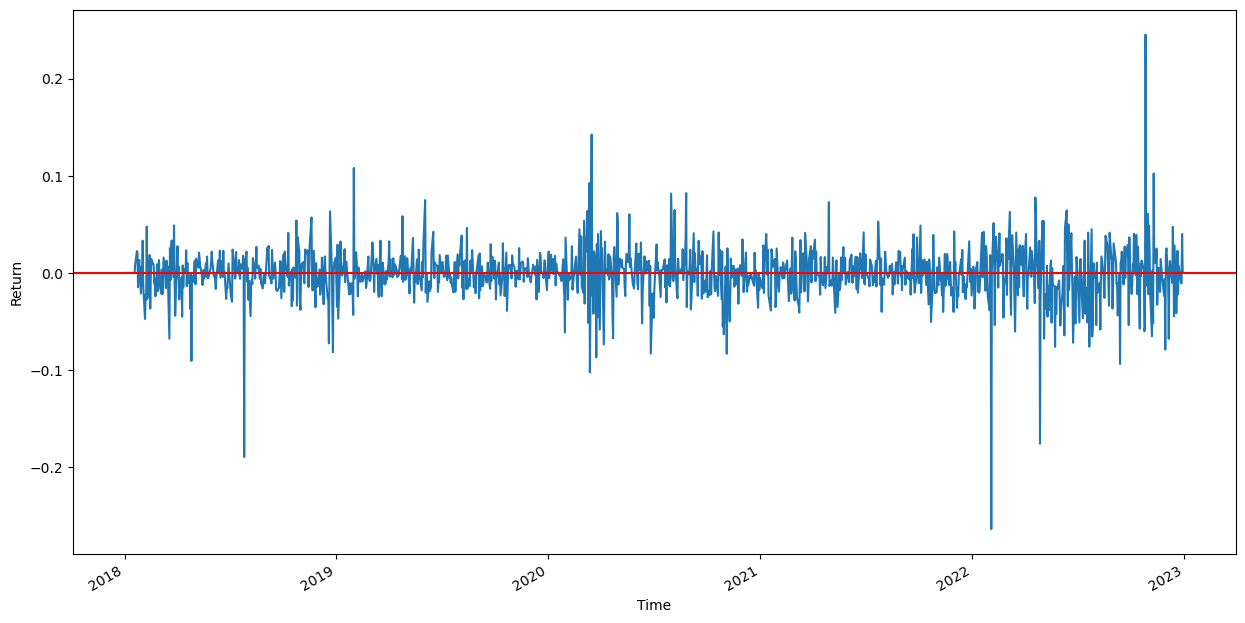

In [13]:
plt.figure(figsize=(15,8))
data['Strategy Return'].plot(label='Strategy Return')
plt.axhline(y=0, color='red')
plt.xlabel('Time')
plt.ylabel('Return')
plt.show()

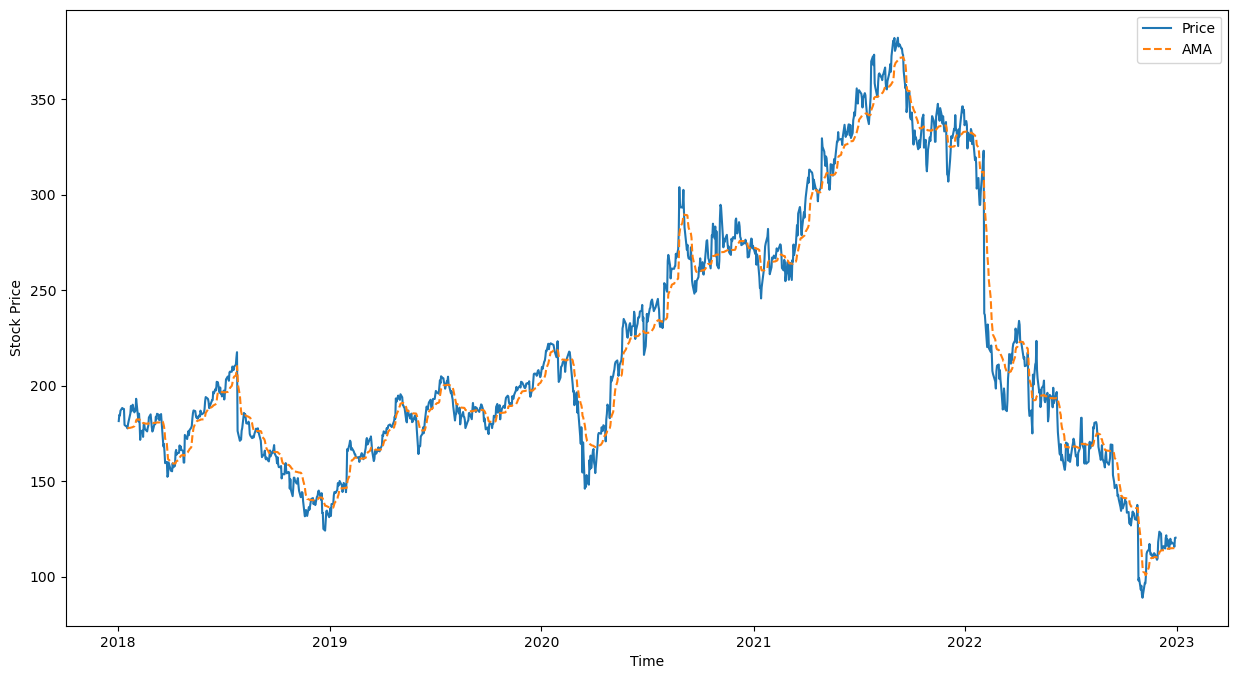

In [14]:
# Plotting the results
plt.figure(figsize=(15, 8))
plt.plot(data['Close'], label='Price')
plt.plot(data['AMA'], label='AMA', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### Performance Metrics

In [15]:
# Cumulative Return
cumulative_return = (1 + data['Strategy Return']).cumprod() - 1
print('Cumulative Return:', cumulative_return.iloc[-1])

Cumulative Return: -0.8260895996803299


In [16]:
# Sharpe Ratio
risk_free_rate = 0.01  # Assuming a 1% annual risk-free rate
excess_returns = data['Strategy Return'] - (risk_free_rate / 252)
sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(252)
print('Sharpe Ratio:', sharpe_ratio)

Sharpe Ratio: -0.6154365216395292


In [17]:
# Max Drawdown
def max_drawdown(returns):
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    return max_drawdown

In [18]:
max_dd = max_drawdown(data['Strategy Return'])
print('Max Drawdown:', max_dd)

Max Drawdown: -0.8611870685868076
